In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'

valid_data_fpath = process_out_dir + 'valid_data.npz'


train_out_dir = '../../02_train/out/'

# we'll rescale data to compare it to training domain
avg_data_scalars_fpath =  train_out_dir + 'avg_lstm_min_max_scalars_3_.pt'
massive_data_scalars_fpath =  train_out_dir + 'massive_lstm_min_max_scalars_1_.pt'
# loss lists for scaling permutation results
avg_loss_list_fpath = train_out_dir + 'avg_lstm_loss_lists_3_.npz'
massive_loss_list_fpath = train_out_dir + 'massive_lstm_loss_lists_1_.npz'


eval_out_dir = '../../03_eval/out/'

# best avg lstm
avg_rand_valid_set_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_coarse_3_.npz'
avg_rand_valid_ice_on_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_ice_on_3_.npz'
avg_rand_valid_ice_off_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_ice_off_3_.npz'
avg_valid_set_permutation_fpath = eval_out_dir + 'avg_lstm_permutation_results_3_.npy'
avg_valid_set_ICE_vals_fpath = eval_out_dir + 'avg_lstm_valid_ice_vals_3_.npy'
avg_valid_set_ICE_preds_fpath = eval_out_dir + 'avg_lstm_valid_ice_preds_3_.npy'

# best massive lstm
massive_rand_valid_set_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_coarse_1_.npz'
massive_rand_valid_ice_on_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_ice_on_1_.npz'
massive_rand_valid_ice_off_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_ice_off_1_.npz'
massive_valid_set_permutation_fpath = eval_out_dir + 'massive_lstm_permutation_results_1_.npy'
massive_valid_set_ICE_vals_fpath = eval_out_dir + 'massive_lstm_valid_ice_vals_1_.npy'
massive_valid_set_ICE_preds_fpath = eval_out_dir + 'massive_lstm_valid_ice_preds_1_.npy'


# Not values, because they are constrained by previous notebooks
n_eg = 50
n_eg_fine = 30
perm_samples = 200
resolution = 25 # ICE

### Values

In [3]:
ice_on_start = 50
ice_on_end = 200

ice_off_start = 200
ice_off_end = 350

<br><br><br>

# Load data

In [4]:
valid_data = np.load(valid_data_fpath, allow_pickle = True)

valid_x = valid_data['x']
valid_dates = valid_data['dates']
valid_DOW = valid_data['DOW']
valid_variables = valid_data['features']

In [5]:
valid_x = torch.from_numpy(valid_x).float()

# load the data scalars and ensure they're the same (data-based, not model-based)
massive_min_max_scalars = torch.load(massive_data_scalars_fpath)
avg_min_max_scalars = torch.load(avg_data_scalars_fpath)
assert torch.equal(massive_min_max_scalars, avg_min_max_scalars)

# rescale valid x
for i in range(valid_x.shape[2]):
    # scale valid set with train min/max
    valid_x[:, :, i] = ((valid_x[:, :, i] - avg_min_max_scalars[i, 0]) /
                        (avg_min_max_scalars[i, 1] - avg_min_max_scalars[i, 0]))

# Load previously calculcated XAI results

In [6]:
# Load expected gradients for both models - coarse, ice on, and ice off
avg_valid_eg = np.load(avg_rand_valid_set_EGs_fpath, allow_pickle = True)
avg_valid_eg_ice_on = np.load(avg_rand_valid_ice_on_EGs_fpath, allow_pickle = True)
avg_valid_eg_ice_off = np.load(avg_rand_valid_ice_off_EGs_fpath, allow_pickle = True)
massive_valid_eg = np.load(massive_rand_valid_set_EGs_fpath, allow_pickle = True)
massive_valid_eg_ice_on = np.load(massive_rand_valid_ice_on_EGs_fpath, allow_pickle = True)
massive_valid_eg_ice_off = np.load(massive_rand_valid_ice_off_EGs_fpath, allow_pickle = True)
# Extract the data
avg_valid_eg_results = avg_valid_eg['results']
avg_valid_eg_results_ice_on = avg_valid_eg_ice_on['results']
avg_valid_eg_results_ice_off = avg_valid_eg_ice_off['results']
massive_valid_eg_results = massive_valid_eg['results']
massive_valid_eg_results_ice_on = massive_valid_eg_ice_on['results']
massive_valid_eg_results_ice_off = massive_valid_eg_ice_off['results']
# Extract the associated IDs
avg_valid_eg_IDs = avg_valid_eg['ids']
avg_valid_eg_IDs_ice_on = avg_valid_eg_ice_on['ids']
avg_valid_eg_IDs_ice_off = avg_valid_eg_ice_off['ids']
massive_valid_eg_IDs = massive_valid_eg['ids']
massive_valid_eg_IDs_ice_on = massive_valid_eg_ice_on['ids']
massive_valid_eg_IDs_ice_off = massive_valid_eg_ice_off['ids']

# Load permutation results
avg_permutation_results = np.load(avg_valid_set_permutation_fpath)
avg_valid_set_ICE_vals = np.load(avg_valid_set_ICE_vals_fpath)
avg_valid_set_ICE_preds = np.load(avg_valid_set_ICE_preds_fpath)

# Load ICE results
massive_permutation_results = np.load(massive_valid_set_permutation_fpath)
massive_valid_set_ICE_vals = np.load(massive_valid_set_ICE_vals_fpath)
massive_valid_set_ICE_preds = np.load(massive_valid_set_ICE_preds_fpath)

In [7]:
avg_valid_loss_list = np.load(avg_loss_list_fpath, allow_pickle = True)['valid_loss']
massive_valid_loss_list = np.load(massive_loss_list_fpath, allow_pickle = True)['valid_loss']

In [8]:
# make sure all the EGs are for the same sequences
assert np.sum(avg_valid_eg_IDs == massive_valid_eg_IDs) / n_eg == 1
assert np.sum(avg_valid_eg_IDs_ice_on == massive_valid_eg_IDs_ice_on) / n_eg_fine == 1
assert np.sum(avg_valid_eg_IDs_ice_off == massive_valid_eg_IDs_ice_off) / n_eg_fine == 1

# Utility functions

In [9]:
def get_total_abs_attribution_by_var(EGs):
    
    ### function that makes all EG attributions positive ###
    ### then sums across batch/lakes and time ###
    ### Ultimately, it aggregates EG attribution magnitude by variable ###
    
    total_abs_attribution_by_var = np.sum(np.sum(np.abs(EGs),
                                                 axis = 0),
                                          axis = 0)
    return total_abs_attribution_by_var


def calc_num_attributed_days(subset_EGs):
    
    ### function that scans through a time series of EGs... ###
    ### then determines where 5% of attributions have accumulated ###
    ### and where 99.99% of attributions end ###
    ### taking the difference to determine how many days account for ~95% of attributions ###

    # subset_EGs are EGs associated with 1 time series (batch size = 1)

    # absolute value of attributions for total affecting-potential on preds
    magnitude_attribution = np.abs(subset_EGs)#avg_valid_eg_results_ice_on[shallowest][i, :, :])
    # determine value of all attributions
    total_attribution = np.sum(magnitude_attribution)

    # through time determine cumulative attribution
    running_attribution = np.cumsum(np.sum(magnitude_attribution, axis = 1))

    # identify where 95% of attribution *starts*
    start_attribution = np.argwhere(running_attribution >= 0.05)[0].item()
    # identify where 99.99% of attribution *ends*, 100% was faulty
    end_attribution = np.argwhere((total_attribution - running_attribution) / total_attribution <= 0.0001)[0].item()
    # calc diff
    num_attributed_days = end_attribution - start_attribution
    
    return num_attributed_days

# Plot sum of absolute values of EGs across space and time

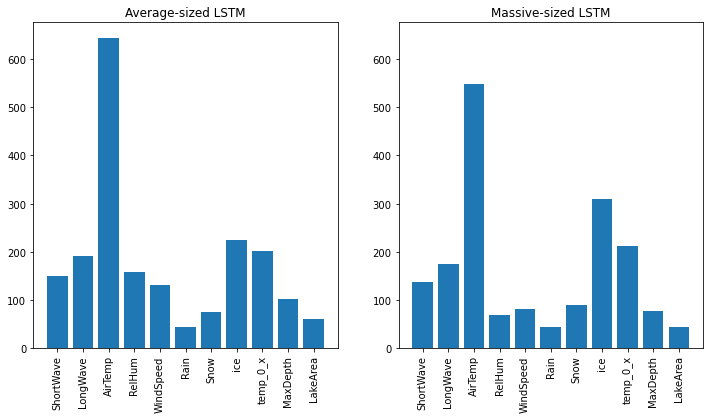

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

# Take the absolute value of EGs and aggregrate them across lakes and days
avg_total_abs_attribution_by_var = get_total_abs_attribution_by_var(avg_valid_eg_results)
massive_total_abs_attribution_by_var = get_total_abs_attribution_by_var(massive_valid_eg_results)

# Determine a shared y-maximum for plotting
ymax = np.max([np.max(avg_total_abs_attribution_by_var),
               np.max(massive_total_abs_attribution_by_var)])
ymax = ymax + ymax*0.05

# Plot both
ax[0].bar(range(len(valid_variables)),
          avg_total_abs_attribution_by_var)
ax[0].set_xticks(range(len(valid_variables)),
                 valid_variables,
                 rotation = 90)
ax[0].set_ylim(0, ymax)
ax[0].set_title('Average-sized LSTM');

ax[1].bar(range(len(valid_variables)),
          massive_total_abs_attribution_by_var)
ax[1].set_xticks(range(len(valid_variables)),
                 valid_variables,
                 rotation = 90)
ax[1].set_ylim(0, ymax)
ax[1].set_title('Massive-sized LSTM');

The relative importance of variables is pretty similar. Both models favor the following top-3 variables:
* air temperature
* process-based estimate of ice (`ice`)
* process-based estimate of surface water temperature (`temp_0_x`)

Relative ordering and magnitude of the top 5 variables looks the highly agreeable except the `massive lstm` places more emphasis on `ice`, seemingly at the expense of relative humidity and wind speed.

<br><br><br><br><br>

# Plot EGs for individual sequences

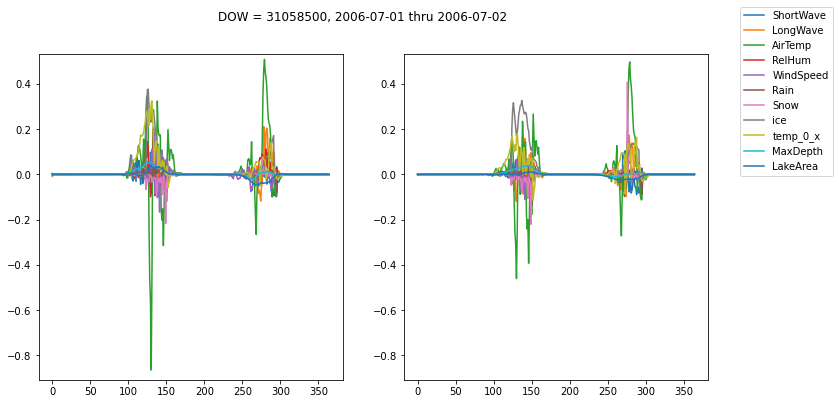

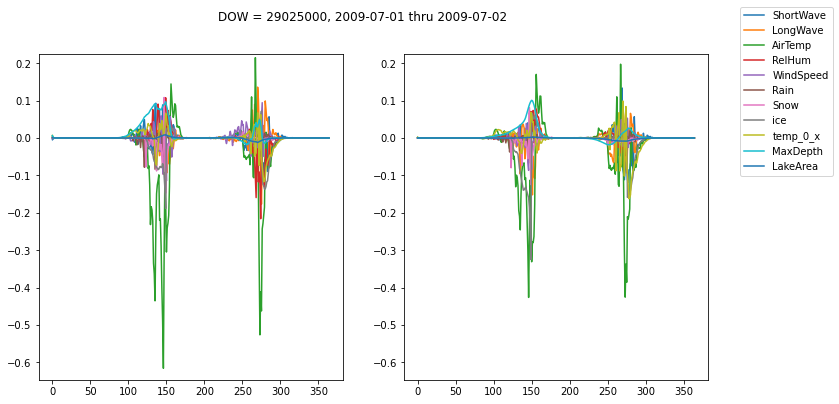

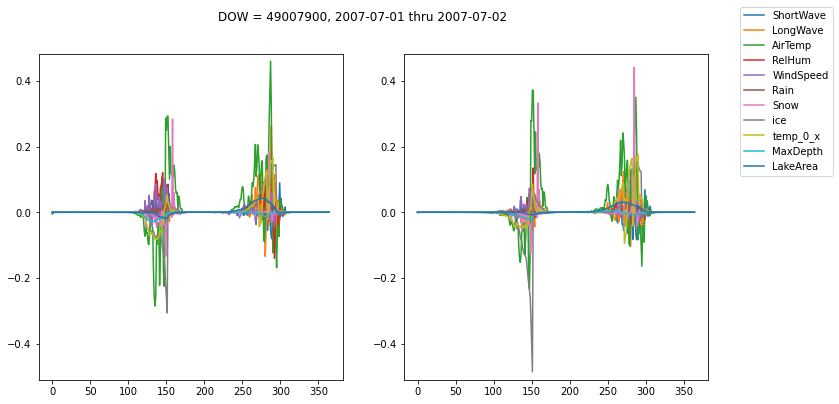

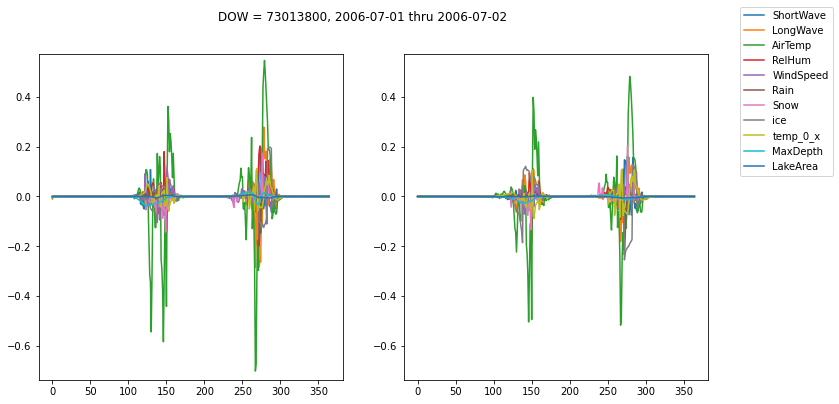

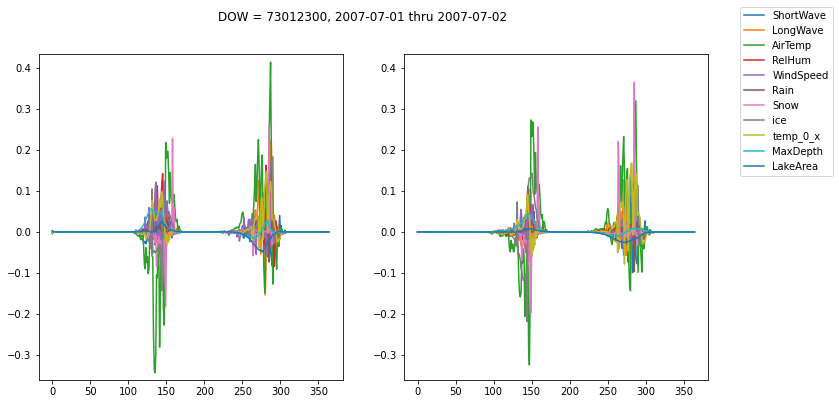

In [11]:
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    
    # draw a random index
    rand_i = np.random.choice(n_eg)
    
    # format some information with that random index
    rand_dow = str(valid_DOW[avg_valid_eg_IDs[rand_i]])
    rand_start_date = valid_dates[avg_valid_eg_IDs[rand_i]][0]
    rand_end_date = valid_dates[avg_valid_eg_IDs[rand_i]][1]
    
    # get info to make axes the same
    avg_cur_egs = avg_valid_eg_results[rand_i, :, :]
    massive_cur_egs = massive_valid_eg_results[rand_i, :, :] 
    ymin = np.min([np.min(avg_cur_egs), np.min(massive_cur_egs)])
    ymax = np.max([np.max(avg_cur_egs), np.max(massive_cur_egs)])
    ymin = ymin + ymin*0.05
    ymax = ymax + ymax*0.05
    
    # plot
    for var_i in range(len(valid_variables)):
        ax[0].plot(avg_valid_eg_results[rand_i, :, var_i])
        ax[1].plot(massive_valid_eg_results[rand_i, :, var_i], label = valid_variables[var_i])
    ax[0].set_ylim(ymin, ymax)
    ax[1].set_ylim(ymin, ymax)
    fig.legend(bbox_to_anchor = (1.05, 1))
    fig.suptitle('DOW = ' + rand_dow + ", " + rand_start_date + ' thru ' + rand_end_date)

Attributions are largely not occurring outside transition periods. That is, no attributions during the heat of summer or the dead of winter.

<br><br><br><br><br>

# EGs targetted at predicted ice on transition

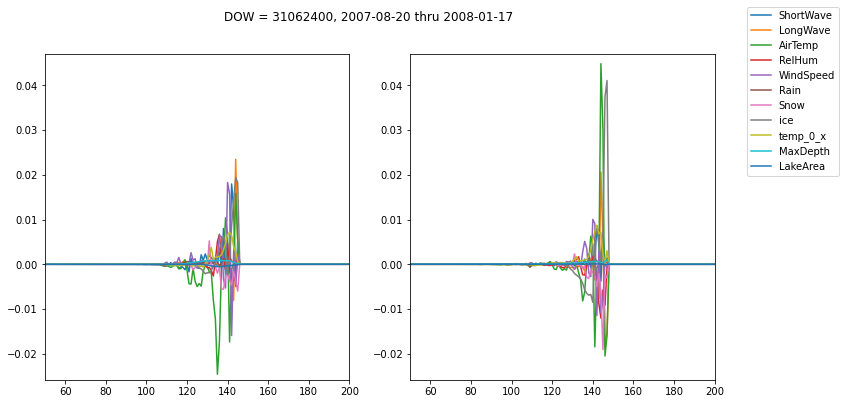

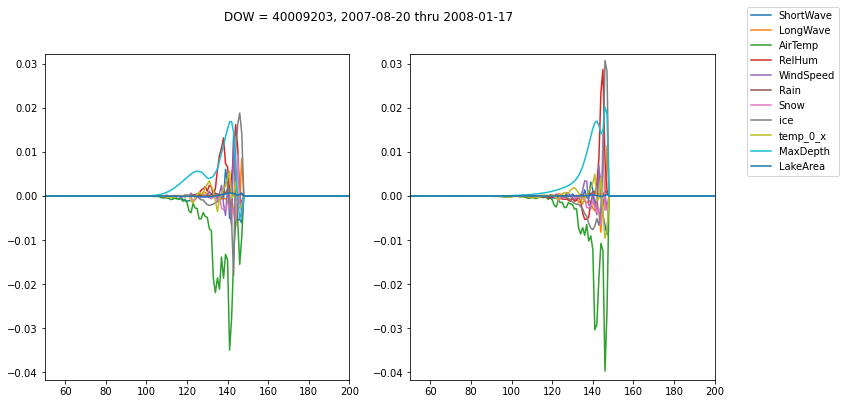

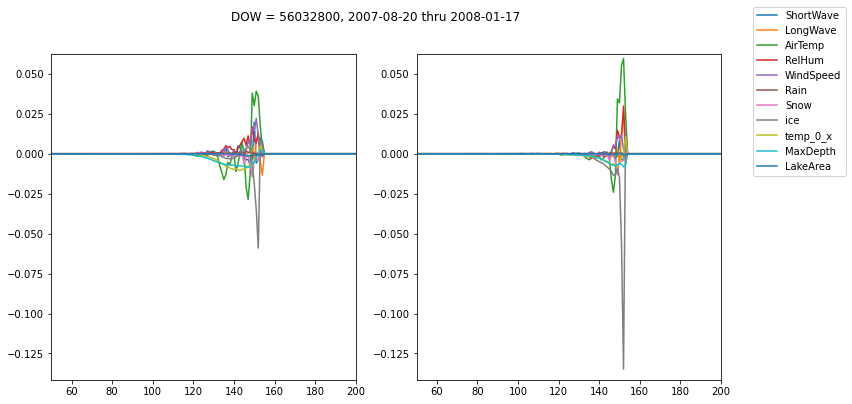

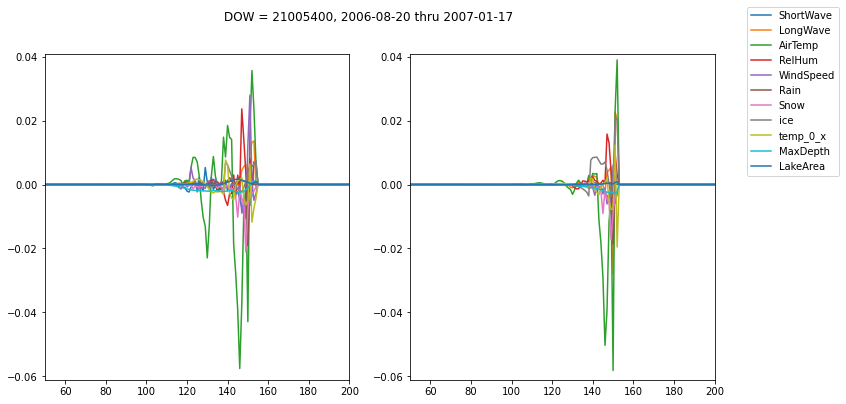

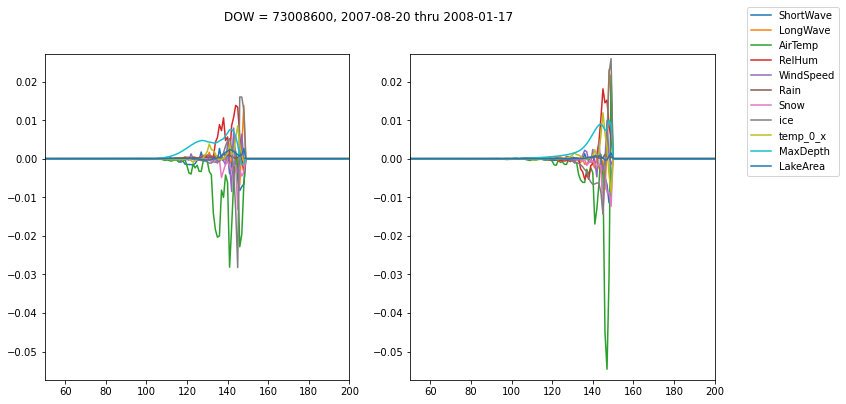

In [12]:
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    
    # draw a random index
    rand_i = np.random.choice(n_eg_fine)
    
    # format some information with that random index
    rand_dow = str(valid_DOW[avg_valid_eg_IDs_ice_on[rand_i]])
    rand_start_date = valid_dates[avg_valid_eg_IDs_ice_on[rand_i]][ice_on_start]
    rand_end_date = valid_dates[avg_valid_eg_IDs_ice_on[rand_i]][ice_on_end]
    
    # get info to make axes the same
    avg_cur_egs = avg_valid_eg_results_ice_on[rand_i, :, :]
    massive_cur_egs = massive_valid_eg_results_ice_on[rand_i, :, :] 
    ymin = np.min([np.min(avg_cur_egs), np.min(massive_cur_egs)])
    ymax = np.max([np.max(avg_cur_egs), np.max(massive_cur_egs)])
    ymin = ymin + ymin*0.05
    ymax = ymax + ymax*0.05
    
    for j in range(len(valid_variables)):
        ax[0].plot(avg_valid_eg_results_ice_on[rand_i, :, j])
        ax[1].plot(massive_valid_eg_results_ice_on[rand_i, :, j], label = valid_variables[j])
    ax[0].set_ylim(ymin, ymax)
    ax[1].set_ylim(ymin, ymax)
    ax[0].set_xlim(ice_on_start, ice_on_end)
    ax[1].set_xlim(ice_on_start, ice_on_end)
    fig.suptitle('DOW = ' + rand_dow + ", " + rand_start_date + ' thru ' + rand_end_date)
    fig.legend(bbox_to_anchor = (1.05, 1))

# EGs targetted at predicted ice off transition

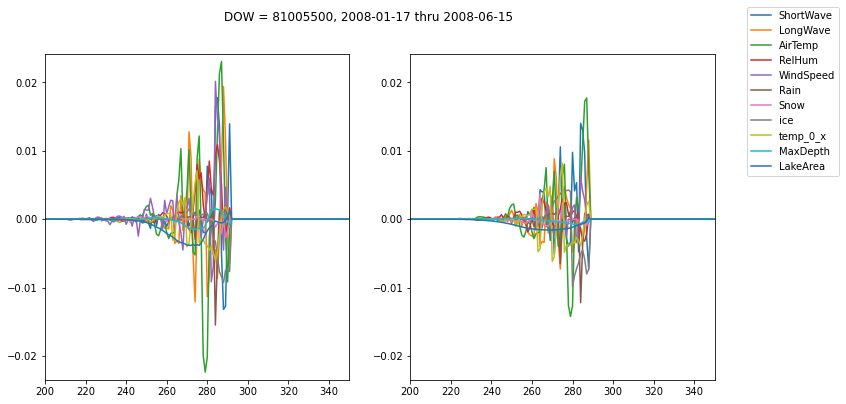

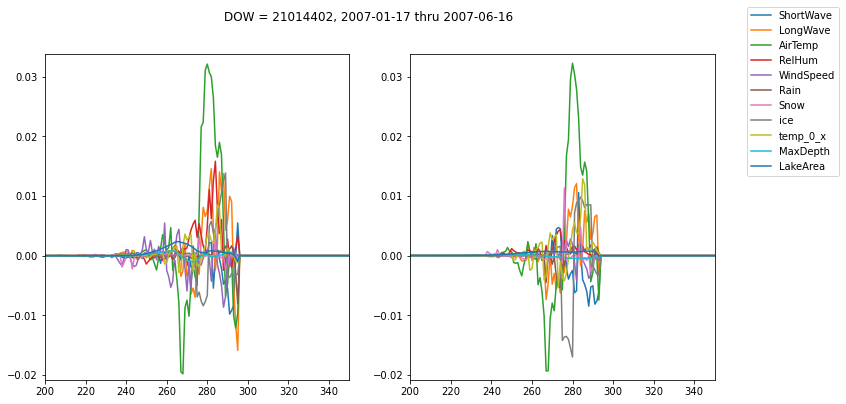

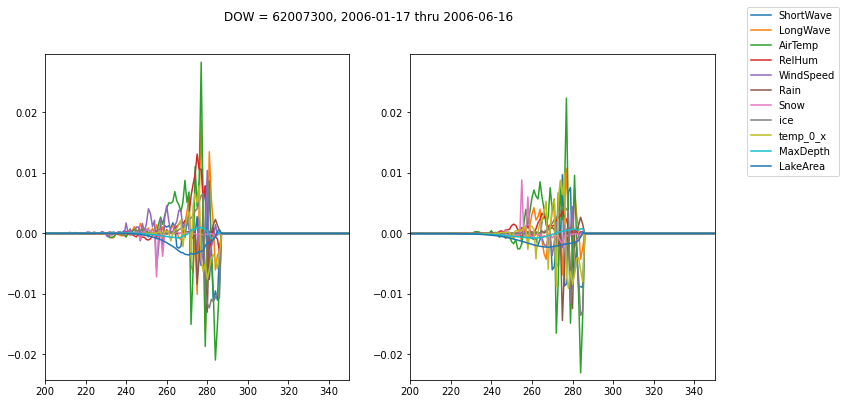

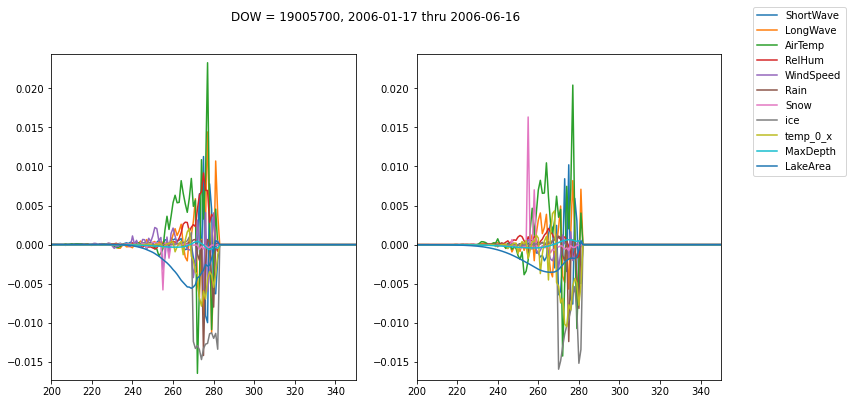

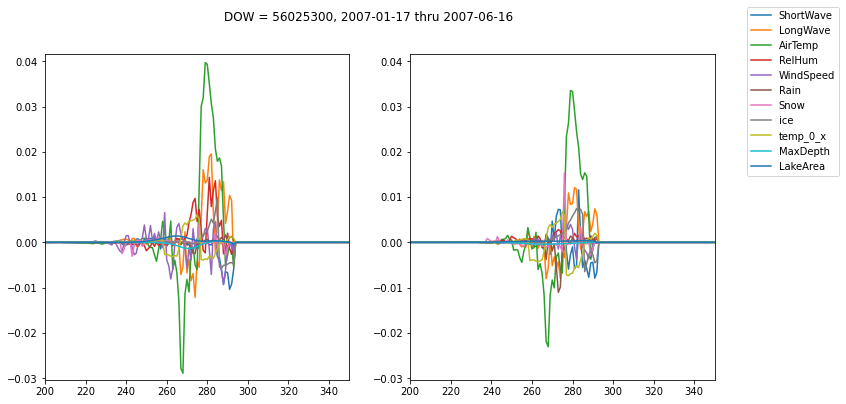

In [13]:
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    
    # draw a random index
    rand_i = np.random.choice(n_eg_fine)
    
    # format some information with that random index
    rand_dow = str(valid_DOW[avg_valid_eg_IDs_ice_off[rand_i]])
    rand_start_date = valid_dates[avg_valid_eg_IDs_ice_off[rand_i]][ice_off_start]
    rand_end_date = valid_dates[avg_valid_eg_IDs_ice_off[rand_i]][ice_off_end]
    
    # get info to make axes the same
    avg_cur_egs = avg_valid_eg_results_ice_off[rand_i, :, :]
    massive_cur_egs = massive_valid_eg_results_ice_off[rand_i, :, :] 
    ymin = np.min([np.min(avg_cur_egs), np.min(massive_cur_egs)])
    ymax = np.max([np.max(avg_cur_egs), np.max(massive_cur_egs)])
    ymin = ymin + ymin*0.05
    ymax = ymax + ymax*0.05
    
    for j in range(len(valid_variables)):
        ax[0].plot(avg_valid_eg_results_ice_off[rand_i, :, j])
        ax[1].plot(massive_valid_eg_results_ice_off[rand_i, :, j], label = valid_variables[j])
    ax[0].set_ylim(ymin, ymax)
    ax[1].set_ylim(ymin, ymax)
    ax[0].set_xlim(ice_off_start, ice_off_end)
    ax[1].set_xlim(ice_off_start, ice_off_end)
    fig.suptitle('DOW = ' + rand_dow + ", " + rand_start_date + ' thru ' + rand_end_date)
    fig.legend(bbox_to_anchor = (1.05, 1))

Compared to ice on prediction, ice off prediction appears to utilize more variables

<br><br><br><br><br>

# Compare how EGs vary when predicting ice-on versus ice-off transition

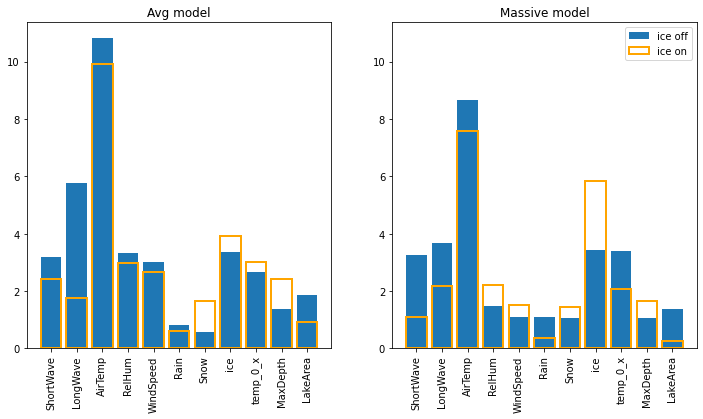

In [14]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

# Take the absolute value of EGs and aggregrate them across lakes and days
avg_total_abs_attribution_by_var_ice_on = get_total_abs_attribution_by_var(avg_valid_eg_results_ice_on)
avg_total_abs_attribution_by_var_ice_off = get_total_abs_attribution_by_var(avg_valid_eg_results_ice_off)
massive_total_abs_attribution_by_var_ice_on = get_total_abs_attribution_by_var(massive_valid_eg_results_ice_on)
massive_total_abs_attribution_by_var_ice_off = get_total_abs_attribution_by_var(massive_valid_eg_results_ice_off)

# Determine a shared y-maximum for plotting
ymax = np.max([np.max(avg_total_abs_attribution_by_var_ice_on),
               np.max(avg_total_abs_attribution_by_var_ice_off),
               np.max(massive_total_abs_attribution_by_var_ice_on),
               np.max(massive_total_abs_attribution_by_var_ice_off)])
ymax = ymax + ymax*0.05

# Plot both ice on and ice off
ax[0].bar(range(len(valid_variables)),
          avg_total_abs_attribution_by_var_ice_off,
          label = 'ice off')
ax[0].bar(range(len(valid_variables)),
          avg_total_abs_attribution_by_var_ice_on,
          color = 'none',
          edgecolor = 'orange',
          linewidth = 2,
          label = 'ice on')

ax[1].bar(range(len(valid_variables)),
          massive_total_abs_attribution_by_var_ice_off,
          label = 'ice off')
ax[1].bar(range(len(valid_variables)),
          massive_total_abs_attribution_by_var_ice_on,
          color = 'none',
          edgecolor = 'orange',
          linewidth = 2,
          label = 'ice on')

# Format plot
ax[0].set_ylim(0, ymax)
ax[1].set_ylim(0, ymax)
ax[0].set_xticks(range(len(valid_variables)),
           valid_variables,
           rotation = 90)
ax[1].set_xticks(range(len(valid_variables)),
           valid_variables,
           rotation = 90)
ax[0].set_title('Avg model')
ax[1].set_title('Massive model')
plt.legend();

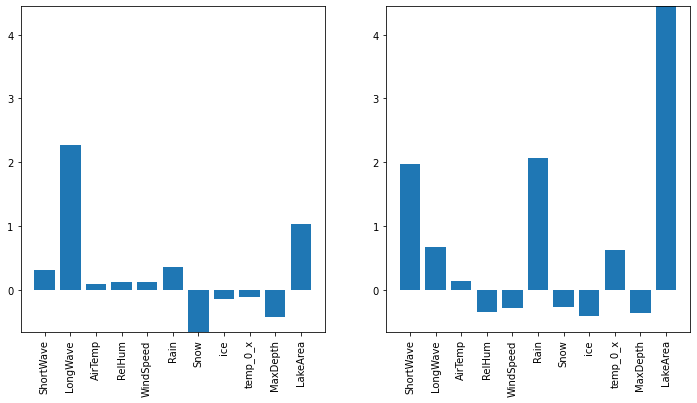

In [15]:
avg_ice_off_percent_change_relative_ice_on = ((avg_total_abs_attribution_by_var_ice_off -
                                               avg_total_abs_attribution_by_var_ice_on) /
                                              avg_total_abs_attribution_by_var_ice_on)

massive_ice_off_percent_change_relative_ice_on = ((massive_total_abs_attribution_by_var_ice_off -
                                                   massive_total_abs_attribution_by_var_ice_on) /
                                                  massive_total_abs_attribution_by_var_ice_on)

ymin = np.min([np.min(avg_ice_off_percent_change_relative_ice_on),
               np.min(massive_ice_off_percent_change_relative_ice_on)])
ymax = np.max([np.max(avg_ice_off_percent_change_relative_ice_on),
               np.max(massive_ice_off_percent_change_relative_ice_on)])

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].bar(range(len(valid_variables)),
          avg_ice_off_percent_change_relative_ice_on,
          label = 'ice off')
ax[1].bar(range(len(valid_variables)),
          massive_ice_off_percent_change_relative_ice_on,
          label = 'ice off')

ax[0].set_ylim(ymin, ymax)
ax[1].set_ylim(ymin, ymax)

ax[0].set_xticks(range(len(valid_variables)),
           valid_variables,
           rotation = 90)
ax[1].set_xticks(range(len(valid_variables)),
           valid_variables,
           rotation = 90);

In [16]:
print(np.mean(avg_ice_off_percent_change_relative_ice_on))
print(np.mean(massive_ice_off_percent_change_relative_ice_on))

0.2705354311583021
0.7522015955992948


On average, both models  assign greater attributions to variables when predicting ice off rather than ice on.

Both models have increased attribution to the following variables when predicting ice off:

* Short wave radiation
* Long wave radiation
* Air temperature (subtle/minor increase)
* Rain
* Lake area

Both models have increased attribution to the following variables when predicting ice on:

* Snow
* Process-based estimate of ice
* Max depth

<br><br><br><br><br>

# How EGs vary by static var

### Extract static variables

SpearmanrResult(correlation=0.30984976685403753, pvalue=0.09565374463550905)

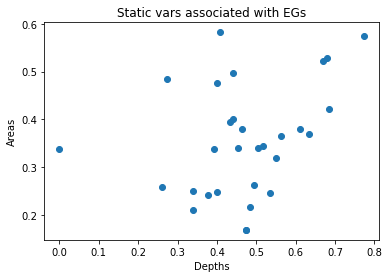

In [17]:
# ID tensor location
depth_i = np.argwhere(valid_variables == 'MaxDepth').item()
area_i = np.argwhere(valid_variables == 'LakeArea').item()
# convert to numpy
#valid_x = valid_x.numpy()
# Extract depths and areas for the subset of data that we have EGs for
depths = valid_x[avg_valid_eg_IDs_ice_on, 0, depth_i]
areas = valid_x[avg_valid_eg_IDs_ice_on, 0, area_i]

# See if/how much they're correlated with each other
plt.scatter(x = depths, y = areas)
plt.xlabel('Depths')
plt.ylabel('Areas')
plt.title('Static vars associated with EGs')
spearmanr(depths, areas)

In [18]:
# For both model sizes and ice on/off...
avg_num_attributed_days_ice_on_ls = []
massive_num_attributed_days_ice_on_ls = []
avg_num_attributed_days_ice_off_ls = []
massive_num_attributed_days_ice_off_ls = []

# Figure out how many days account for 95% of EG attributions
for i in range(n_eg_fine):
    avg_num_attributed_days_ice_on_ls.append(calc_num_attributed_days(avg_valid_eg_results_ice_on[i, :, :]))
    massive_num_attributed_days_ice_on_ls.append(calc_num_attributed_days(massive_valid_eg_results_ice_on[i, :, :]))
    avg_num_attributed_days_ice_off_ls.append(calc_num_attributed_days(avg_valid_eg_results_ice_off[i, :, :]))
    massive_num_attributed_days_ice_off_ls.append(calc_num_attributed_days(massive_valid_eg_results_ice_off[i, :, :]))

## Ice on

### Plot static variable values versus an approximation of how long the model remembers

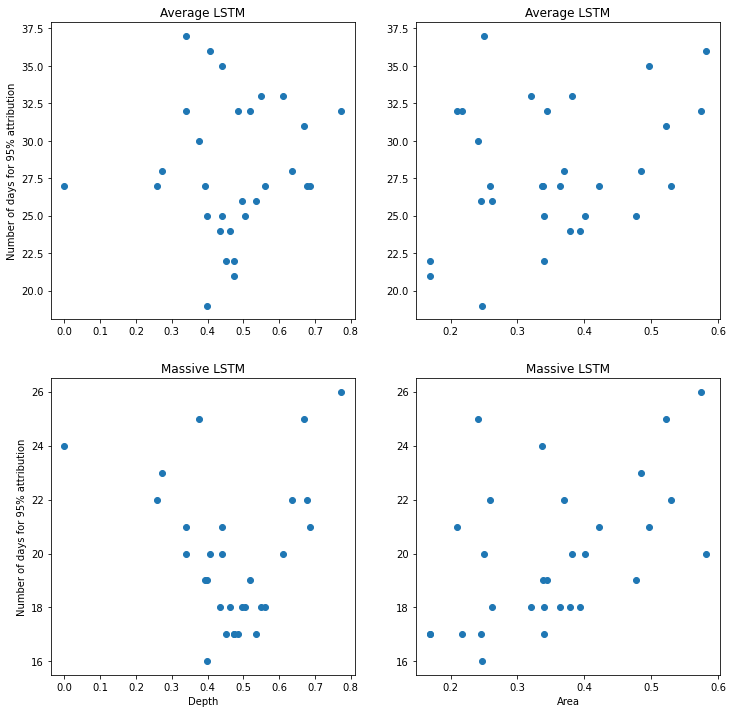

In [19]:
fig, ax = plt.subplots(2, 2, figsize = (12, 12))

# plot static variable values vs how many days account for 95% of EG attributions
ax[0, 0].scatter(depths, avg_num_attributed_days_ice_on_ls)
ax[0, 1].scatter(areas, avg_num_attributed_days_ice_on_ls)
ax[1, 0].scatter(depths, massive_num_attributed_days_ice_on_ls)
ax[1, 1].scatter(areas, massive_num_attributed_days_ice_on_ls)

ax[0, 0].set_ylabel('Number of days for 95% attribution')
ax[1, 0].set_ylabel('Number of days for 95% attribution')
ax[1, 0].set_xlabel('Depth')
ax[1, 1].set_xlabel('Area')
for i in range(2):
    ax[0, i].set_title('Average LSTM');
    ax[1, i].set_title('Massive LSTM');

In [20]:
# Get associated correlations and p-values
for model in [avg_num_attributed_days_ice_on_ls, massive_num_attributed_days_ice_on_ls]:
    print(spearmanr(depths, model))
    print(spearmanr(areas, model))

SpearmanrResult(correlation=0.07142969059520927, pvalue=0.7075920437935821)
SpearmanrResult(correlation=0.24678665841511857, pvalue=0.18860604786581786)
SpearmanrResult(correlation=-0.04962003274395618, pvalue=0.7945614002782346)
SpearmanrResult(correlation=0.4917701273152768, pvalue=0.005778723529089369)


The only static variable that appears to significantly affect LSTM memory is `LakeArea`, which significantly (`p << 0.05`) increases memory of the `massive lstm` with greater area. This is counterintuitive because when everything else is held constant, increased `LakeArea` should result in more interaction with the air, meaning that the lake should have more dynamic behavior?

`LakeArea` is non-significantly correlated with `MaxDepth` (`corr = 0.31`, `p = 0.09`). The associated increased memory and increased depth is more intuitive, but this is not supported.

`MaxDepth` appears to correlate very well quadratically with memory in the `massive lstm` but this is not quantified and may be a stretch.

<br><br><br><br><br>

## Ice off

### Plot static variable values versus an approximation of how long the model remembers

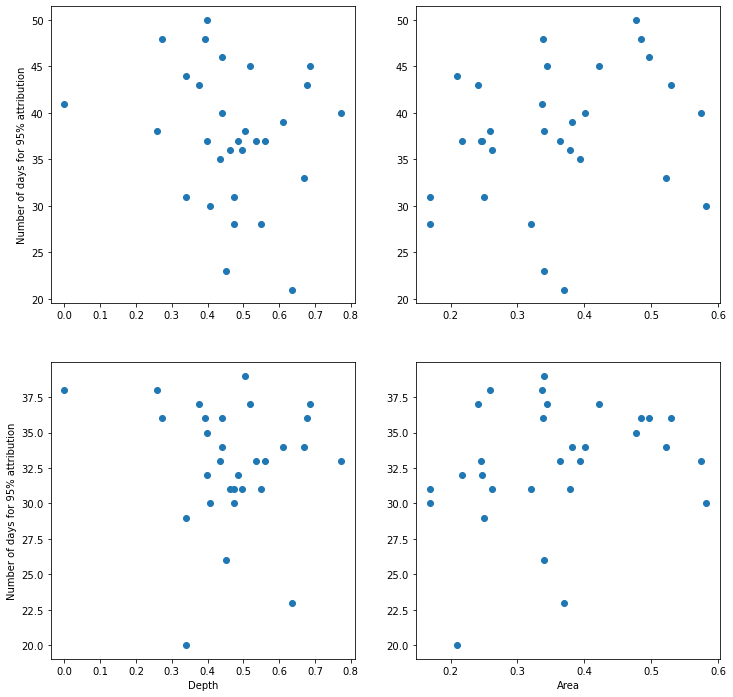

In [21]:
fig, ax = plt.subplots(2, 2, figsize = (12, 12))

ax[0, 0].scatter(depths, avg_num_attributed_days_ice_off_ls)
ax[0, 1].scatter(areas, avg_num_attributed_days_ice_off_ls)
ax[1, 0].scatter(depths, massive_num_attributed_days_ice_off_ls)
ax[1, 1].scatter(areas, massive_num_attributed_days_ice_off_ls)

ax[0, 0].set_ylabel('Number of days for 95% attribution')
ax[1, 0].set_ylabel('Number of days for 95% attribution')
ax[1, 0].set_xlabel('Depth')
ax[1, 1].set_xlabel('Area');

In [22]:
for model in [avg_num_attributed_days_ice_off_ls, massive_num_attributed_days_ice_off_ls]:
    print(spearmanr(depths, model))
    print(spearmanr(areas, model))

SpearmanrResult(correlation=-0.21844362032752185, pvalue=0.24617214144625543)
SpearmanrResult(correlation=0.2517003738999755, pvalue=0.17967381651830033)
SpearmanrResult(correlation=-0.06506483834441146, pvalue=0.7326563481251376)
SpearmanrResult(correlation=0.2565962160500373, pvalue=0.171073874422005)


For ice off, neither static variable appears to signficantly correlate with the memory of either of the best models.

<br><br><br><br><br>

# Compare memory for both models between ice on and ice off

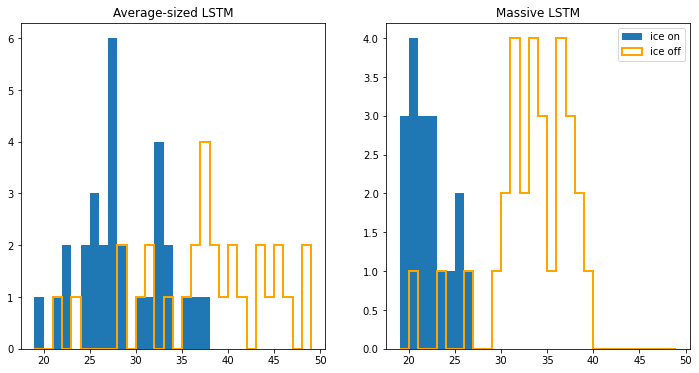

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ymin = min(min(avg_num_attributed_days_ice_on_ls), min(avg_num_attributed_days_ice_off_ls))
ymax = max(max(avg_num_attributed_days_ice_on_ls), max(avg_num_attributed_days_ice_off_ls))

ax[0].hist(avg_num_attributed_days_ice_on_ls, bins = range(ymin, ymax))
ax[0].hist(avg_num_attributed_days_ice_off_ls, bins = range(ymin, ymax),
           linewidth = 2, histtype = 'step', color = 'orange')

ax[1].hist(massive_num_attributed_days_ice_on_ls, bins = range(ymin, ymax),
           label = 'ice on')
ax[1].hist(massive_num_attributed_days_ice_off_ls, bins = range(ymin, ymax),
           linewidth = 2, histtype = 'step', color = 'orange',
           label = 'ice off')
plt.legend()

ax[0].set_title('Average-sized LSTM')
ax[1].set_title('Massive LSTM');

In [24]:
np.mean(avg_num_attributed_days_ice_on_ls), np.mean(avg_num_attributed_days_ice_off_ls)

(28.0, 37.6)

In [25]:
np.mean(massive_num_attributed_days_ice_on_ls), np.mean(massive_num_attributed_days_ice_off_ls)

(19.933333333333334, 32.833333333333336)

The `avg lstm` remembers longer for both ice on and ice off prediction relative to the `massive lstm`, but both models remember longer when predicting ice off relative to ice on

<br><br><br><br><br>

# View Permutation

In [26]:
# original validation losses for scaling
avg_valid_loss = avg_valid_loss_list[avg_valid_loss_list != 0].min()
massive_valid_loss = massive_valid_loss_list[massive_valid_loss_list != 0].min()

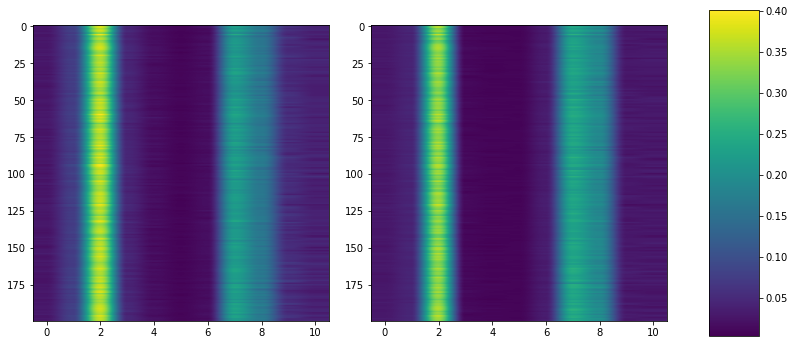

In [27]:
fig, ax = plt.subplots(1, 3, figsize = (13, 6), gridspec_kw={'width_ratios': [6, 6, 1]})

avg_change_relative_to_base = (avg_permutation_results - avg_valid_loss) / avg_valid_loss
massive_change_relative_to_base = (massive_permutation_results - massive_valid_loss) / massive_valid_loss

vmin = np.min([np.min(avg_change_relative_to_base), np.min(massive_change_relative_to_base)])
vmax = np.max([np.max(avg_change_relative_to_base), np.max(massive_change_relative_to_base)])

im = ax[0].imshow(avg_change_relative_to_base,
             aspect = len(valid_variables) / perm_samples,
             vmin = vmin, vmax = vmax)

ax[1].imshow(massive_change_relative_to_base,
             aspect = len(valid_variables) / perm_samples,
             vmin = vmin, vmax = vmax)

fig.colorbar(im, cax = ax[2]);

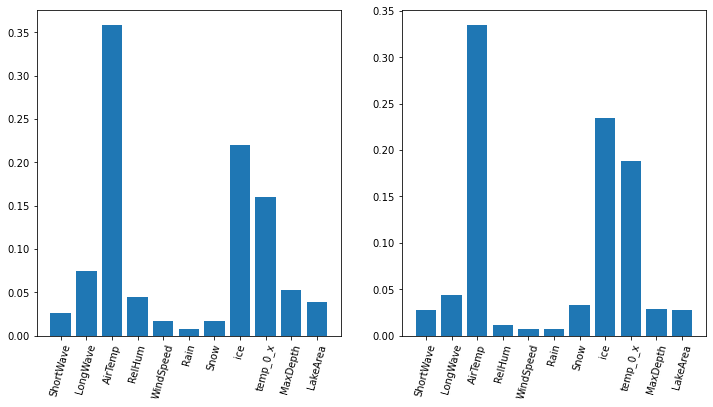

In [28]:
# original validation losses for scaling
avg_valid_loss = avg_valid_loss_list[avg_valid_loss_list != 0].min()
massive_valid_loss = massive_valid_loss_list[massive_valid_loss_list != 0].min()


fig, ax = plt.subplots(1, 2, figsize = (12, 6))

# plot changes in rmse
ax[0].bar(valid_variables, (np.mean(avg_permutation_results, 0) - avg_valid_loss) / avg_valid_loss)
ax[1].bar(valid_variables, (np.mean(massive_permutation_results, 0) - massive_valid_loss) / massive_valid_loss)
# fix labels
ax[0].set_xticks(range(len(valid_variables)), valid_variables, rotation=75)
ax[1].set_xticks(range(len(valid_variables)), valid_variables, rotation=75);

Permutation-based results largely agree with EG results. EG results focus on raw prediction, while permutation focuses on change in performance. 

Permutation results more greatly emphasize the importance of the top-3 variables

<br><br><br><br><br>

# View PDP (average of ICE)

Rather than just importance and timing, let's also get an idea for how prediction vary over the range of input variables. This will be performed across many quantiles, including the training min and max, and values beyond the training min and max.

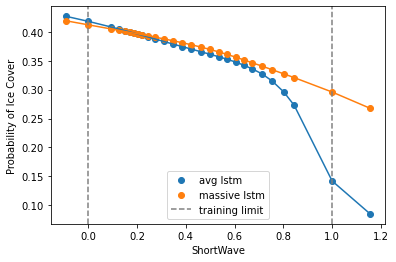

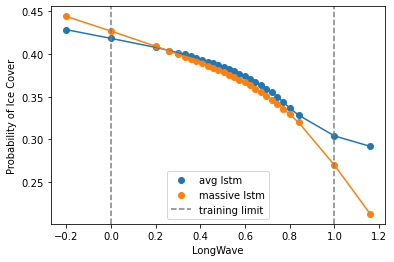

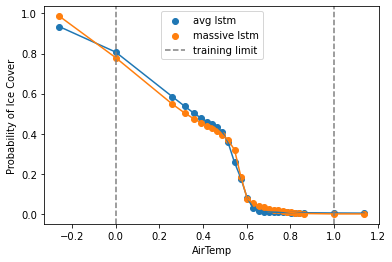

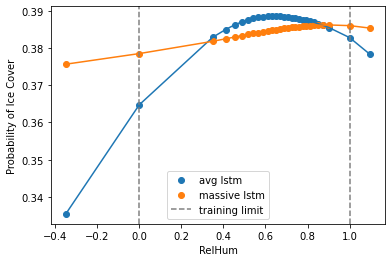

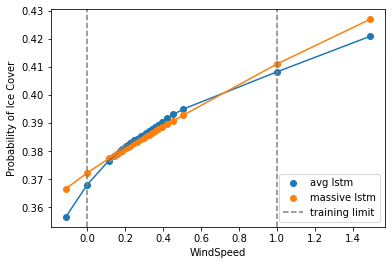

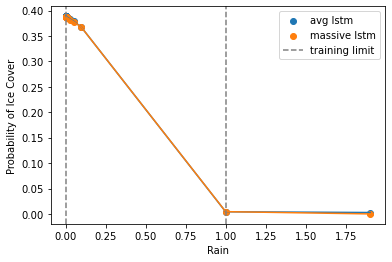

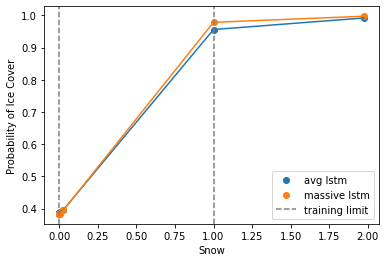

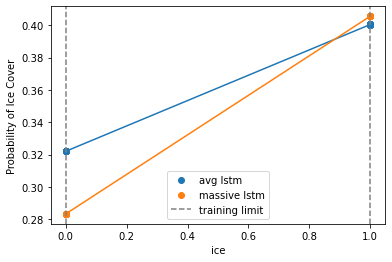

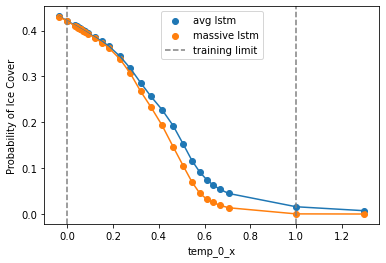

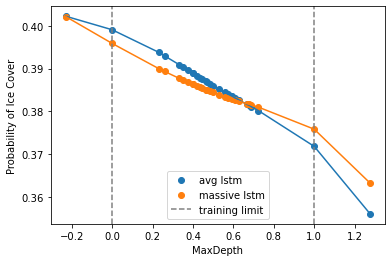

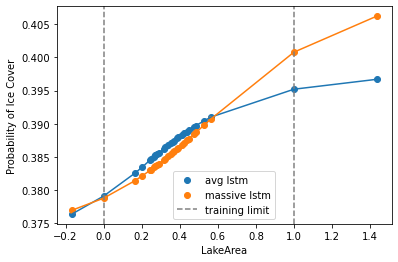

In [29]:
for var_index in range(len(valid_variables)):
    plt.plot(avg_valid_set_ICE_vals[var_index],
             # reshape lumps all lakes and times together by variable
             np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1))
    plt.scatter(avg_valid_set_ICE_vals[var_index],
                np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'avg lstm')
    plt.plot(massive_valid_set_ICE_vals[var_index],
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1))
    plt.scatter(massive_valid_set_ICE_vals[var_index],
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'massive lstm')
    plt.ylabel('Probability of Ice Cover')
    plt.xlabel(valid_variables[var_index])
    plt.axvline(0, color = 'grey', linestyle = '--', label = 'training limit')
    plt.axvline(1, color = 'grey', linestyle = '--')
    plt.legend()
    plt.pause(0.0001)

PDP take-aways:
1. Across variables, the models behave very similarly for >90% of the input values.
  * For the top-3 variables, the continuous valued variables highly resemble each other.
2. The `massive lstm` does not exclusively behave wilder at extremes. The model that does display wilder behavior displays none linear behavior which extrapolates divergently into out-of-sample values.
  * Notably, it does for `LakeArea` and `LongWave`
  * `avg lstm` displays wilder behavior for `RelHum` and `ShortWave`
3. These plots may demonstrate why EGs assign different attribution between models.
  * E.g., `avg lstm`s weighted `RelHum` and `WindSpeed` higher than `massive lstm`s. Likewise, the `avg lstm` assigns a slight nonlinear effect to these variables which prescribes higher probability of ice over these ~90% of their values

<br><br><br><br><br>

# Conclusions

* At a coarse, high-level the `avg lstm` and `massive lstm` behave similarly (beyond performance metrics).
<br>

* Expected gradients and permutated-based importance assigned similar variable importance, with permutation-based methods more heavily emphasizing the importance of the top-3 variables. Both methods and models assign top-3 importance to:
  * Air temperature
  * Process-based estimate of ice
  * Process-based estimate of surface water temperature
<br>
<br>

* Similarity of variable importance persists beyond the top-3, but the following disagreements are notable:
  * The `massive lstm` weights process-based estimates of ice higher.
  * The `avg lstm` weights relative humidity and wind speed higher.
<br>
<br>

* For both models, input values occurring in the heat of summer and the dead of winter are not assigned predictive attribution.
<br>

* For both models, predicting the ice off transition assigns predictive attribution to more variables and further back in time.
  * Along these lines, the `avg lstm` remembers for longer than the `massive lstm` in both scenarios.
  * Notably, when predicting ice on both models assigned higher attribution to snowfall and lake depth, and when predicting ice off both models assigned higher attribution to rainfall and lake area.
    * Measures of incoming radiation were also assigned higher attribution for predicting ice off.
<br> 
<br>
   
* Static variables (area and depth) did not consistently affect the size of the attributed temporal window (where 95% of predictive attribution was assigned, unit = days). One exception is that the `massive lstm`'s attributed temporal window for ice off prediction was positively and signficantly correlated with lake area, implying that more expansive lakes required more historical information.
<br>

* Across 90% of the range of input values, the models behave very similarly at high-level trend directions and shapes.
* The `massive lstm` (>18 million parameters) did not exclusively behave wilder in out-of-sample input values relative to the `avg lstm` (~2000 parameters)
  * The `massive lstm` extrapolates into new values of lake area and long wave radiation more divergently
  * The `avg lstm` extrapolates into new values of relative humidity and short wave radiation more divergently
  
  
*Caveat*: PDP-approach for exploring prediction at out-of-sample input values varies one input variable at a time into new values while the others inputs are using in-sample values. This has the limitation of considering potentially unrealistic values (e.g., unrealistic combinations of rain fall and incoming radiation) and may not accurately consider how multiple variable may covary into out-of-sample space.